# Exporting LLM Runs and Feedback
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langsmith-cookbook/blob/main/exploratory-data-analysis/exporting-llm-runs-and-feedback/llm_run_etl.ipynb)

Understanding how your LLM app interacts with users is crucial. LangSmith offers a number of useful ways to interact with and annotate trace data directly in the app. You can also easily query that trace data so you can process it with your tool of choice.

This tutorial guides you through exporting LLM traces and associated feedback from LangSmith for further analysis. By the end, you'll be able to export a flat table of LLM run information that you can analyze, enrich, or use for model training.

Before we start, ensure you have a LangChain project with some logged traces. You can generate some using almost any of the other recipes in this cookbook. The overall steps will be:

1. Query runs, filtering by time, tags, or other attributes.
2. Add in associated feedback metrics (if captured)
3. Export to analysis tool.

To make things easy, we will be loading the data into a pandas dataframe. We will be doing the ETL on LLM runs logged from LangChain, but you can modify the code below to handle whatever schema is used by your deployed model. Now let's set up our environment!

#### Setup

First, install langsmith and pandas and set your langsmith API key to connect to your project.
We will also install LangChain to use one of its formatting utilities.

In [ ]:
# %pip install -U langchain langsmith pandas seaborn --quiet

In [ ]:
# %env LANGCHAIN_API_KEY=""

In [1]:
from langsmith import Client

client = Client()

## 1. Query Runs

Now that the environment is ready, we will load the run data from LangSmith. Let's try loading all our LLM runs from the past week. To do so, we will filter for runs with the "llm" `run_type` from the past week.

Please reference the [docs](https://docs.smith.langchain.com/tracing/use-cases/export-runs/local) for guidance on more complex filters (using metadata, tags, and other attributes).


In [2]:
from datetime import datetime, timedelta

start_time = datetime.utcnow() - timedelta(days=7)

runs = list(client.list_runs(
    project_name="YOUR PROJECT NAME",
    run_type="llm",
    start_time=start_time,
))

In [3]:
import pandas as pd

df = pd.DataFrame(
    [{
        "name": run.name,
        "model": run.extra['invocation_params']['model'], # The parameters used when invoking the model are nested in the extra info
        **run.inputs,
        **(run.outputs or {}),
        "error":run.error,
        "latency": (run.end_time - run.start_time).total_seconds() if run.end_time else None, # Pending runs have no end time
        "prompt_tokens": run.prompt_tokens,
        "completion_tokens": run.completion_tokens,
        "total_tokens": run.total_tokens,
    }
          for run in runs
    ],
    index=[run.id for run in runs]
)

df.head(5)

,name,model,messages,run,llm_output,generations,error,latency,prompt_tokens,completion_tokens,total_tokens
4ddeed83-f438-4d77-b6bb-ec26ea0824af,ChatOpenAI,gpt-3.5-turbo-16k,"[{'id': ['langchain', 'schema', 'messages', 'S...",NaN,NaN,[{'text': 'Coffee can have both positive and n...,None,14.133700,2028.0,350.0,2378.0
51d22986-33d2-416b-911f-1083c719b768,ChatOpenAI,gpt-3.5-turbo-16k,"[{'id': ['langchain', 'schema', 'messages', 'H...",NaN,NaN,[{'text': 'Is coffee beneficial for our health...,None,0.907260,191.0,7.0,198.0
fa5e83ff-497d-411c-97d4-6cd878ba80f6,ChatOpenAI,gpt-3.5-turbo-16k,"[{'id': ['langchain', 'schema', 'messages', 'H...",NaN,NaN,[{'text': 'Is coffee beneficial for our health...,None,0.588772,180.0,7.0,187.0
54861172-33ec-4414-b907-0e75b4918125,ChatOpenAI,gpt-3.5-turbo-16k,"[{'id': ['langchain', 'schema', 'messages', 'S...",NaN,NaN,[{'text': 'Hello! How can I assist you today?'...,None,0.584520,1202.0,9.0,1211.0
a1cf4e28-d0e5-45f2-8faf-f314858380ca,ChatOpenAI,gpt-3.5-turbo-16k,"[{'id': ['langchain', 'schema', 'messages', 'S...",NaN,NaN,[{'text': 'You're welcome! If you have any mor...,None,1.072372,2488.0,22.0,2510.0


#### Stringify

If you are using a regular "Completion" style model that expects string input and returns a single string output, you can easily view the text data without further formatting.

For chat models, the message dictionaries contain a lot of information that can be hard to read. If you want to _just_ see the string, you may consider parsing the message content into a human-readable format. You can use LangChain's `get_buffer_string` helper to do so, as shown below.

In [4]:
from typing import Optional

from langchain.load.load import load
from langchain.schema import get_buffer_string

def stringify_inputs(inputs: dict) -> dict:
    return {
        "messages": get_buffer_string(load(inputs['messages']))
    }

def stringify_outputs(outputs: Optional[dict]) -> dict:
    if not outputs:
        return {}
    if isinstance(outputs['generations'], dict):
        # Function Message
        return {
            "generated_message": get_buffer_string([load(outputs['generations']['message'])])
        }
    else:
        return {
            "generated_message": get_buffer_string([load(outputs['generations'][0]['message'])])
        }

df = pd.DataFrame(
    [{
        "model": run.extra['invocation_params']['model'], # The parameters used when invoking the model are nested in the extra info    
        **stringify_inputs(run.inputs),
        **stringify_outputs(run.outputs),
        "error":run.error,
        "latency": (run.end_time - run.start_time).total_seconds() if run.end_time else None, # Pending runs have no end time
        "prompt_tokens": run.prompt_tokens,
        "completion_tokens": run.completion_tokens,
        "total_tokens": run.total_tokens,
    }
          for run in runs
    ],
    index=[run.id for run in runs]
)

df.head(5)

,model,messages,generated_message,error,latency,prompt_tokens,completion_tokens,total_tokens
4ddeed83-f438-4d77-b6bb-ec26ea0824af,gpt-3.5-turbo-16k,System: \n You are an expert programmer and...,AI: Coffee can have both positive and negative...,None,14.133700,2028.0,350.0,2378.0
51d22986-33d2-416b-911f-1083c719b768,gpt-3.5-turbo-16k,Human: Given the following conversation and a ...,AI: Is coffee beneficial for our health?,None,0.907260,191.0,7.0,198.0
fa5e83ff-497d-411c-97d4-6cd878ba80f6,gpt-3.5-turbo-16k,Human: Given the following conversation and a ...,AI: Is coffee beneficial for our health?,None,0.588772,180.0,7.0,187.0
54861172-33ec-4414-b907-0e75b4918125,gpt-3.5-turbo-16k,System: \n You are an expert programmer and...,AI: Hello! How can I assist you today?,None,0.584520,1202.0,9.0,1211.0
a1cf4e28-d0e5-45f2-8faf-f314858380ca,gpt-3.5-turbo-16k,System: \n You are an expert programmer and...,AI: You're welcome! If you have any more quest...,None,1.072372,2488.0,22.0,2510.0


## 2. Load Feedback

Improving your model hinges on understanding user signals. In LangSmith, you can access both explicit (like thumbs up/down) and implicit signals (like click-through rates) through the feedback API. Feedback can be structured (contains a numeric score) or unstructured (comments/corrections). You'll find quantitative statistics on the run object's `run.feedback_stats` attribute if available, and you can directly fetch the full feedback entries by calling `list_feedback()` by run_id.

**Note**, LLM runs are often nested in chains, and feedback is likely assigned to the root run of a trace. To find associated feedback, consider querying the feedback for the root run. This way the feedback is evenly assigned to any LLM calls within a trace.

In [5]:
from functools import lru_cache
from langsmith.schemas import Run

@lru_cache(maxsize=1000)
def _fetch_run(run_id: str) -> Run:
    return client.read_run(run_id)

def get_root(run: Run) -> Run:
    if run.execution_order == 1:
        return run
    return _fetch_run(str(run.parent_run_ids[-1]))

def get_feedback(r: Run) -> dict:
    if not r.feedback_stats:
        return {}
    return {k: v['avg'] for k, v in r.feedback_stats.items()}

def get_root_feedback(run: Run) -> dict:
    root_run = get_root(run)
    return get_feedback(root_run)

In [6]:
df = pd.DataFrame(
    [{
        "model": run.extra['invocation_params']['model'],
        **stringify_inputs(run.inputs),
        **stringify_outputs(run.outputs),
        **get_root_feedback(run),
        "error":run.error,
        "latency": (run.end_time - run.start_time).total_seconds() if run.end_time else None, # Pending runs have no end time
        "prompt_tokens": run.prompt_tokens,
        "completion_tokens": run.completion_tokens,
        "total_tokens": run.total_tokens,
    }
          for run in runs
    ],
    index=[run.id for run in runs]
)

In [7]:
df[~pd.isna(df['user_score'])].head(10)

,model,messages,generated_message,error,latency,prompt_tokens,completion_tokens,total_tokens,user_score
c1f718f7-0466-4234-8eda-4c8dd06f08a7,gpt-3.5-turbo-16k,Human: Given the following conversation and a ...,"AI: What is the meaning of pressing ""f"" in onl...",None,1.358865,588.0,13.0,601.0,1.0
a34c03ad-f24e-4113-a32e-f53417fd999d,gpt-3.5-turbo-16k,Human: Given the following conversation and a ...,AI: Can the code responses be defaulted to Jav...,None,1.033514,1884.0,9.0,1893.0,1.0
f06b745b-10c5-42b2-87fd-f08472a997b0,gpt-3.5-turbo-16k,Human: Given the following conversation and a ...,AI: Can you provide an example of a chat funct...,None,0.885441,264.0,16.0,280.0,1.0
2161535b-f2aa-4f68-8815-9679e9bc42f7,gpt-3.5-turbo-16k,System: You are an expert developer tasked ans...,AI: The LangChain Expression Language is a lan...,None,16.265123,1654.0,298.0,1952.0,1.0
ec79f4c8-9957-412b-84ee-4373b0d00340,gpt-3.5-turbo-16k,System: You are an expert developer tasked ans...,"AI: {'name': 'Documentation', 'arguments': '{\...",None,1.104964,356.0,19.0,375.0,1.0
2ef17693-7a1e-45b1-82e1-b49423a408ea,gpt-3.5-turbo-16k,System: You are an expert developer tasked ans...,AI: LangChain is a Python package that provide...,None,16.196424,1648.0,353.0,2001.0,1.0
7b3b9603-8a2f-433f-8b4e-0a5f7947f562,gpt-3.5-turbo-16k,System: You are an expert developer tasked ans...,"AI: {'name': 'Documentation', 'arguments': '{\...",None,1.077405,738.0,17.0,755.0,1.0
92aa38b5-b9ee-4803-8257-45c7c6f9e1ec,gpt-3.5-turbo-16k,System: You are an expert developer tasked ans...,"AI: {'name': 'Documentation', 'arguments': '{\...",None,1.089527,694.0,17.0,711.0,1.0
74bac7f6-1ac9-4288-9e33-900659ae74a6,gpt-3.5-turbo-16k,System: You are an expert developer tasked ans...,AI: Retrieval Augmented Generation (RAG) is a ...,None,14.711333,3311.0,777.0,4088.0,1.0
6e363d67-35e7-4a12-b728-4e1959b02b0e,gpt-3.5-turbo-16k,System: You are an expert developer tasked ans...,"AI: {'name': 'Documentation', 'arguments': '{\...",None,0.888599,359.0,20.0,379.0,1.0


## 3. Analyze Data

Once you have the data in flat form, you can export to many compatible tools, from tabular storage like Airtable and Excel, to annotation tools like [LabelBox](https://docs.labelbox.com/reference/text-file) to other text analysis tools like [Lilac](../lilac/lilac.ipynb) or [Nomic](https://atlas.nomic.ai/).

For the purpose of this tutorial, we will wrap things up with a simple token plot. Check out our other recipes for more involved analysis.

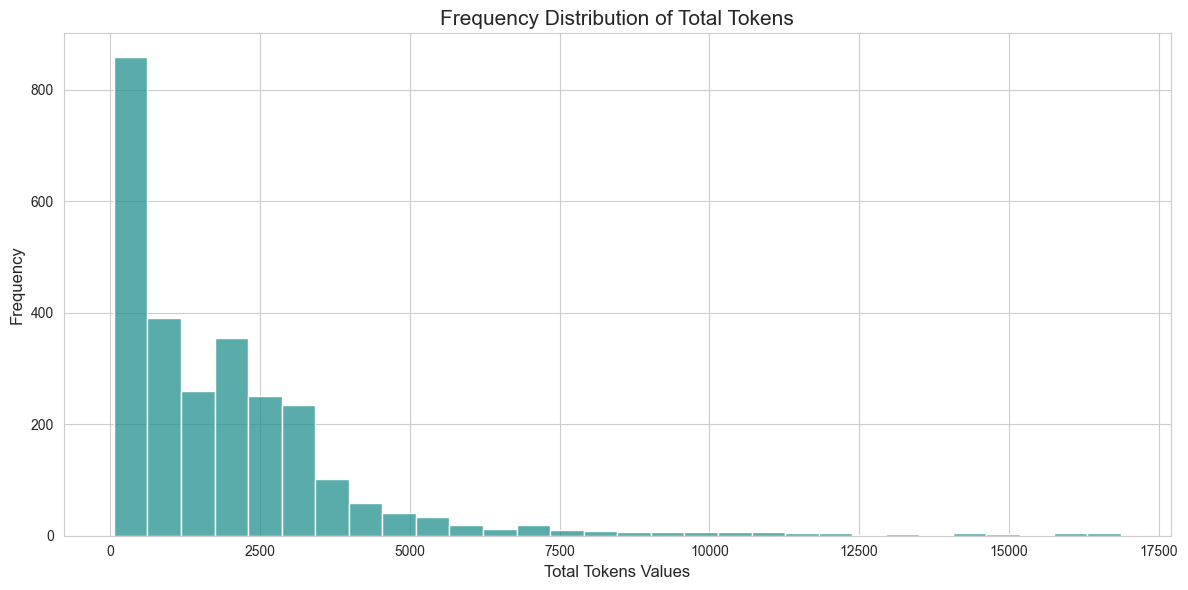

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style
sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))
sns.histplot(df['total_tokens'], kde=False, bins=30, color=sns.color_palette("viridis", as_cmap=True)(0.5))

plt.title('Frequency Distribution of Total Tokens', fontsize=15)
plt.xlabel('Total Tokens Values', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()


## Conclusion

In this walkthrough, you queried LLM runs and loaded associated trace feedback all into a simple tabular format. This makes it easy to export to other analytical tools and data stores.